<a href="https://colab.research.google.com/github/RocaPiedra/Visualizing-Semantic-Segmentation/blob/main/PyTorch_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Finetuning tuto

In [4]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ukni1x4m
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ukni1x4m
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263901 sha256=693b536d93e63caed1368fc309d1401bf1ffba010f59d2fe77ee8cea0f60ebc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-z1jds2dl/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [5]:
from os import path
import urllib.request
import zipfile

if path.isdir('PennFudanPed'):
  print('dataset already downloaded')
else:
  # download the Penn-Fudan dataset
  url = 'https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip'
  urllib.request.urlretrieve(url, filename = 'PennFudanPed.zip')
  # extract it in the current folder
  with zipfile.ZipFile('PennFudanPed.zip', 'r') as zip_ref:
    zip_ref.extractall()
  print('dataset downloaded and extracted')

dataset already downloaded


Text(0.5, 1.0, 'Mask')

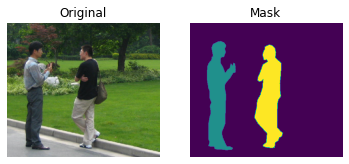

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

image_path = 'PennFudanPed/PNGImages/FudanPed00096.png'
original = Image.open('PennFudanPed/PNGImages/FudanPed00074.png')

mask = Image.open('PennFudanPed/PedMasks/FudanPed00074_mask.png')
mask.putpalette([
    0,0,0,
    255,0,0,
    255,255,0,
    255,153,0,
])
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(np.asarray(original))
plt.axis('off')
plt.title('Original')
fig.add_subplot(1,2,2)
plt.imshow(np.asarray(mask))
plt.axis('off')
plt.title('Mask')

In [7]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms = None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'PNGImages'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'PedMasks'))))

    def __getitem__(self,idx):
        img_path = os.path.join(self.root, 'PNGImages', self.imgs[idx])
        mask_path = os.path.join(self.root, 'PedMasks', self.masks[idx])
        
        img = Image.open(img_path).convert('RGB')

        mask = Image.open(mask_path)
        mask = np.array(mask)
        obj_ids = np.unique(mask)
        #remove first id (background)
        obj_ids = obj_ids[1:]

        masks = mask == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
          pos = np.where(masks[i])
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1] * (boxes[:, 2] - boxes[:, 0]))
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms is not None:
          img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
dataset = PennFudanDataset('PennFudanPed/')

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

#prepare for custom dataset
def get_instance_segmentation_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    
    return model

In [10]:
%%shell
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at be376084 version check against PyTorch's CUDA version


In [11]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [12]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle = True,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn) 
data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                          batch_size=1,
                                          shuffle = False,
                                          num_workers=4,
                                          collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
num_classes = 2 #background and person
model = get_instance_segmentation_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9,
                            weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)


cuda


In [15]:
num_epochs = 10
for epoch in range(num_epochs):
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
  lr_scheduler.step()
  evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:21  lr: 0.000090  loss: 2.7294 (2.7294)  loss_classifier: 0.7856 (0.7856)  loss_box_reg: 0.2727 (0.2727)  loss_mask: 1.6452 (1.6452)  loss_objectness: 0.0134 (0.0134)  loss_rpn_box_reg: 0.0126 (0.0126)  time: 1.3567  data: 0.2824  max mem: 2582
Epoch: [0]  [ 1/60]  eta: 0:00:55  lr: 0.000174  loss: 2.7294 (2.8228)  loss_classifier: 0.7856 (0.8201)  loss_box_reg: 0.1707 (0.2217)  loss_mask: 1.6452 (1.7644)  loss_objectness: 0.0060 (0.0097)  loss_rpn_box_reg: 0.0012 (0.0069)  time: 0.9382  data: 0.1495  max mem: 2582
Epoch: [0]  [ 2/60]  eta: 0:00:47  lr: 0.000259  loss: 2.7294 (2.7302)  loss_classifier: 0.7856 (0.7933)  loss_box_reg: 0.2727 (0.2505)  loss_mask: 1.6452 (1.6694)  loss_objectness: 0.0134 (0.0117)  loss_rpn_box_reg: 0.0025 (0.0054)  time: 0.8121  data: 0.1043  max mem: 2582
Epoch: [0]  [ 3/60]  eta: 0:00:41  lr: 0.000344  loss: 2.5452 (2.5895)  loss_classifier: 0.7396 (0.7673)  loss_box_reg: 0.2727 (0.2990)  loss_mask: 1.4795 (1.5026)  loss_ob

In [1]:
img, _ = dataset_test[20]
print(np.shape(img))
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])

plt.imshow(np.asarray(img.mul(255).permute(1, 2, 0).byte().numpy()))

NameError: ignored

In [ ]:
# ogimg, _ = dataset_test[20]
# print(np.shape(ogimg))
img = Image.open('DSC_0257.JPG')
img = np.array(img)
print(img)

img_tensor = torch.from_numpy(img)
# print(img_tensor, np.shape(img_tensor))
shapes = []
shapes = np.shape(img)
print('original image shapes:', shapes)
new_shape = [shapes[2], shapes[0], shapes[1]]
print('new shape to use:', new_shape)
img_flip =np.reshape(img, new_shape)
print('reshaped shape:', np.shape(img_flip))
H_diff = img[:,:,0] - img_flip[0,:,:]
print(img[0], img_flip[1, H_diff])
# img = Image.fromarray(img.mul(1/255).permute(1, 2, 0))
# print(np.shape(img))

[[[104 151 205]
  [104 151 205]
  [105 152 208]
  ...
  [126 179 229]
  [127 180 230]
  [128 181 231]]

 [[105 152 208]
  [104 151 207]
  [105 152 208]
  ...
  [128 180 230]
  [129 181 231]
  [128 181 231]]

 [[103 152 208]
  [102 151 207]
  [102 151 207]
  ...
  [128 180 230]
  [129 181 231]
  [130 182 232]]

 ...

 [[182 193 195]
  [187 197 196]
  [191 197 193]
  ...
  [116 116 144]
  [112 108 133]
  [114 106 127]]

 [[184 195 199]
  [185 195 196]
  [186 195 192]
  ...
  [139 136 153]
  [124 120 135]
  [122 116 130]]

 [[184 195 199]
  [184 194 196]
  [185 194 193]
  ...
  [155 153 158]
  [147 142 148]
  [137 132 136]]]
original image shapes: (3264, 4928, 3)
new shape to use: [3, 3264, 4928]
reshaped shape: (3, 3264, 4928)


(465, 536, 3)


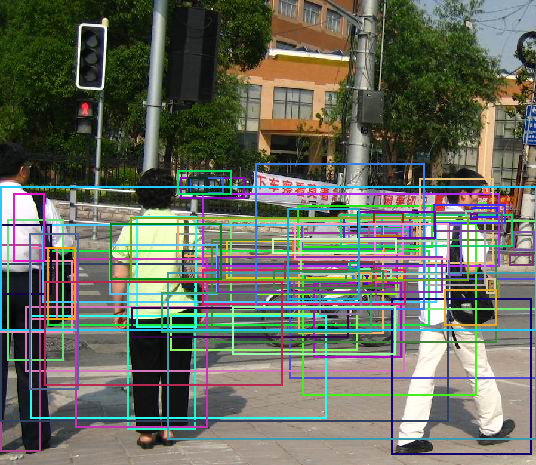

In [15]:
from PIL import ImageDraw
import random

og = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
print(np.shape(og))
vertex = prediction[0]['boxes'].cpu().detach().numpy()

draw = ImageDraw.Draw(og)
for v in vertex:
  r = int(random.random()*255)
  b = int(random.random()*255)
  g = int(random.random()*255) 
  color = (r,g,b)
  draw.rectangle(v, fill=None, outline=color, width=2)
og.save('out_file.png')
Image.open('out_file.png')

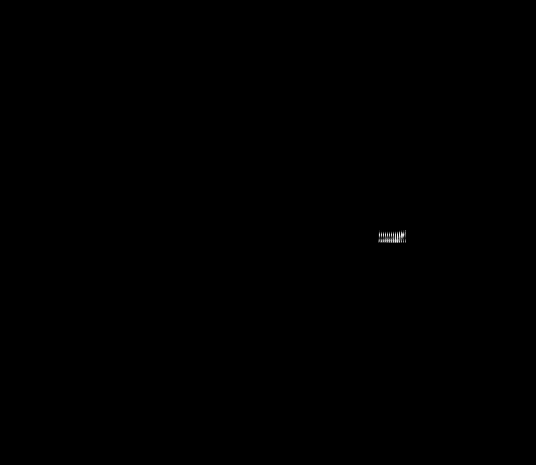

In [16]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [17]:
#class for different mask generation
class mask_mod():
  def __init__(self, masks, filter):
    self.masks = masks
    self.filter = filter

  #this function generates a mask for all predictions
  def generate_full_mask(self):
    full_mask = self.masks[0,0]
    for i in range(1,len(self.masks)):
      full_mask = full_mask + self.masks[i,0]
    full_mask[full_mask>=self.filter] = 1
    Image.fromarray(full_mask.mul(255).byte().cpu().numpy())

    return full_mask

  def generate_binary_mask(self):
    full_mask = self.masks[0,0]
    for i in range(1,len(self.masks)):
      full_mask = full_mask + self.masks[i,0]
    full_mask[full_mask>=self.filter] = 1
    full_mask[full_mask<self.filter] = 0
    Image.fromarray(full_mask.mul(255).byte().cpu().numpy())
    return full_mask

#array of mask prediction from GPU to PIL.Image.fromarray readable
def array_to_pillow(array):
  result = array.mul(255).byte().cpu().numpy()
  return result

Testing full masks!

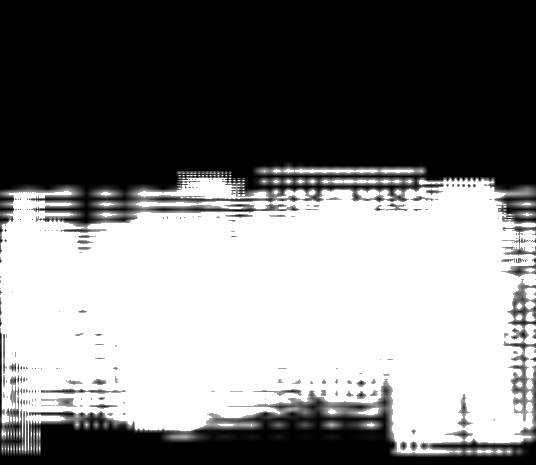

In [18]:
filtering_param = 0.7
maskmodder = mask_mod(prediction[0]['masks'],filtering_param)
full = maskmodder.generate_full_mask()
Image.fromarray(array_to_pillow(full))

Testing Binary masks!

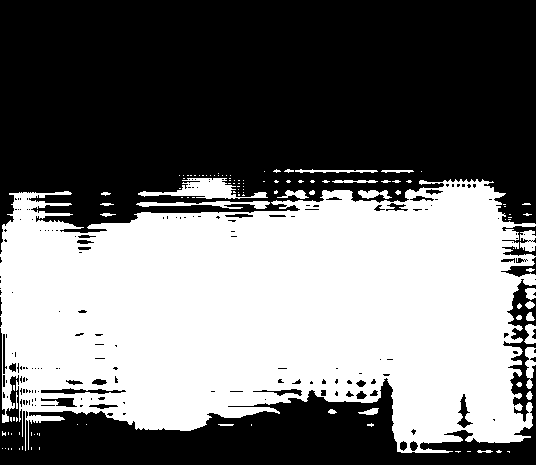

In [19]:
binary = maskmodder.generate_binary_mask()
Image.fromarray(array_to_pillow(binary))